## It aggregates data from multiple sources into a single dataset and simple MLP and LogisticRegression.

### Necessary library imports

In [1]:
import pandas as pd
import _sqlite3 as db
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from torch import nn
from torch.utils.data import TensorDataset, DataLoader, WeightedRandomSampler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import torch
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import StratifiedKFold, cross_val_score
import pickle, json
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay
import joblib
import seaborn as sns
import sklearn as sk
import sklearn.metrics as metrics
from regex import Match
from sklearn.metrics import roc_curve, auc, precision_recall_curve

### Extraction data from sqlite DB

In [5]:
# function for tables extraction
def extract_tables(cursor):
    for row in cursor.execute("SELECT name FROM sqlite_master WHERE type='table';"):
        print(row)

# Extraction tables from European Soccer Database (https://www.kaggle.com/datasets/hugomathien/soccer?resource=download)
con_euro = db.connect('Data/EuroSoccer.sqlite')
cursor = con_euro.cursor()

print("Tables from European Soccer Database:\n")
extract_tables(cursor)
print('\n')

# Extraction tables from World Soccer DB: archive of odds [01-JUN-2021] (https://www.kaggle.com/datasets/sashchernuh/european-football/data?select=database.sqlite)
con_world = db.connect('Data/WorldSoccer.sqlite')
cursor = con_world.cursor()

print("Tables from WorldSoccer Database:\n")
extract_tables(cursor)

with open('../notebooks/embeddings_data.pkl', 'rb') as f:
    embeddings_data = pickle.load(f)

print(f"Downloaded embeddings for {len(embeddings_data['player_id_to_idx'])} players")

Tables from European Soccer Database:

('sqlite_sequence',)
('Player_Attributes',)
('Player',)
('Match',)
('League',)
('Country',)
('Team',)
('Team_Attributes',)


Tables from WorldSoccer Database:

Downloaded embeddings for 11060 players


### Extraction data from tables and .csv files to DataFrames

In [7]:
# Extraction data from Euro Soccer
match_table = pd.read_sql_query("SELECT * FROM Match;", con_euro)
team_table = pd.read_sql_query("SELECT * FROM Team;", con_euro)
team_attributes = pd.read_sql_query("SELECT * FROM Team_Attributes;", con_euro)
country_table = pd.read_sql_query("SELECT * FROM Country;", con_euro)
players = pd.read_sql_query("SELECT * FROM Player;", con_euro)
player_attributes = pd.read_sql_query("SELECT * FROM Player_Attributes;", con_euro)
leagues_table = pd.read_sql_query("SELECT * FROM League;", con_euro)

# Look up of all data
print(f"match_table: {match_table.columns.tolist()}\n")
print(f"team_table: {team_table.columns.tolist()}\n")
print(f"team_attributes: {team_attributes.columns.tolist()}\n")
print(f"country_table: {country_table.columns.tolist()}\n")
print(f"players: {players.columns.tolist()}\n")
print(f"player_attributes: {player_attributes.columns.tolist()}\n")
print(f"leagues: {leagues_table.columns.tolist()}\n")

match_table: ['id', 'country_id', 'league_id', 'season', 'stage', 'date', 'match_api_id', 'home_team_api_id', 'away_team_api_id', 'home_team_goal', 'away_team_goal', 'home_player_X1', 'home_player_X2', 'home_player_X3', 'home_player_X4', 'home_player_X5', 'home_player_X6', 'home_player_X7', 'home_player_X8', 'home_player_X9', 'home_player_X10', 'home_player_X11', 'away_player_X1', 'away_player_X2', 'away_player_X3', 'away_player_X4', 'away_player_X5', 'away_player_X6', 'away_player_X7', 'away_player_X8', 'away_player_X9', 'away_player_X10', 'away_player_X11', 'home_player_Y1', 'home_player_Y2', 'home_player_Y3', 'home_player_Y4', 'home_player_Y5', 'home_player_Y6', 'home_player_Y7', 'home_player_Y8', 'home_player_Y9', 'home_player_Y10', 'home_player_Y11', 'away_player_Y1', 'away_player_Y2', 'away_player_Y3', 'away_player_Y4', 'away_player_Y5', 'away_player_Y6', 'away_player_Y7', 'away_player_Y8', 'away_player_Y9', 'away_player_Y10', 'away_player_Y11', 'home_player_1', 'home_player_2', 

### Creating labels

In [8]:
def create_match_result(row):
    if row['home_team_goal'] > row['away_team_goal']:
        return 1  # Home win
    elif row['home_team_goal'] < row['away_team_goal']:
        return -1  # Away win
    else:
        return 0  # Draw

match_table['result'] = match_table.apply(create_match_result, axis=1)
match_table['result_label'] = match_table['result'].map({1: 'home_win', 0: 'draw', -1: 'away_win'})

### The main combination of match data with information about teams and leagues

In [9]:
matches_enhanced = match_table.merge(
    leagues_table, left_on='league_id', right_on='id', how='left', suffixes=('', '_league')
).merge(
    country_table, left_on='country_id', right_on='id', how='left', suffixes=('', '_country')
)
matches_enhanced = matches_enhanced.merge(
    team_table, left_on='home_team_api_id', right_on='team_api_id',
    how='left', suffixes=('', '_home_team')
)
matches_enhanced.rename(columns={
    'team_long_name': 'home_team_name',
    'team_short_name': 'home_team_short'
}, inplace=True)
matches_enhanced = matches_enhanced.merge(
    team_table, left_on='away_team_api_id', right_on='team_api_id',
    how='left', suffixes=('', '_away_team')
)
matches_enhanced.rename(columns={
    'team_long_name': 'away_team_name',
    'team_short_name': 'away_team_short'
}, inplace=True)

print(f"The main dataset has been created: {matches_enhanced.shape}")

The main dataset has been created: (25979, 132)


### Function to extract data about players for specific match

In [11]:
def get_match_players(match_row, team_type='home'):
    player_columns = [f'{team_type}_player_{i}' for i in range(1, 12)]
    players = []
    for col in player_columns:
        if col in match_row and pd.notna(match_row[col]):
            players.append(int(match_row[col]))
    return players

def get_players_attributes_for_match(player_ids, match_date, player_attributes):
    if not player_ids:
        return pd.DataFrame()
    match_date = pd.to_datetime(match_date)
    relevant_attributes = player_attributes[
        player_attributes['player_api_id'].isin(player_ids)
    ].copy()

    if relevant_attributes.empty:
        return pd.DataFrame()
    relevant_attributes['date'] = pd.to_datetime(relevant_attributes['date'])
    player_attrs_list = []
    for player_id in player_ids:
        player_data = relevant_attributes[
            (relevant_attributes['player_api_id'] == player_id) &
            (relevant_attributes['date'] <= match_date)
        ]

        if not player_data.empty:
            latest_attr = player_data.loc[player_data['date'].idxmax()]
            player_attrs_list.append(latest_attr)

    if player_attrs_list:
        return pd.DataFrame(player_attrs_list)
    else:
        return pd.DataFrame()
def aggregate_team_player_stats(team_players_attrs):
    if team_players_attrs.empty:
        return {}
    key_attributes = [
        'overall_rating', 'potential', 'crossing', 'finishing', 'heading_accuracy',
        'short_passing', 'long_passing', 'ball_control', 'acceleration', 'sprint_speed',
        'agility', 'shot_power', 'stamina', 'strength', 'aggression', 'interceptions',
        'positioning', 'vision', 'marking', 'standing_tackle', 'sliding_tackle'
    ]

    aggregated_stats = {}
    for attr in key_attributes:
        if attr in team_players_attrs.columns and not team_players_attrs[attr].isna().all():
            aggregated_stats[f'{attr}_mean'] = team_players_attrs[attr].mean()
            aggregated_stats[f'{attr}_max'] = team_players_attrs[attr].max()
            aggregated_stats[f'{attr}_min'] = team_players_attrs[attr].min()
            aggregated_stats[f'{attr}_std'] = team_players_attrs[attr].std()
    if 'preferred_foot' in team_players_attrs.columns:
        foot_counts = team_players_attrs['preferred_foot'].value_counts()
        aggregated_stats['right_foot_players'] = foot_counts.get('right', 0)
        aggregated_stats['left_foot_players'] = foot_counts.get('left', 0)
    if 'attacking_work_rate' in team_players_attrs.columns:
        work_rate_counts = team_players_attrs['attacking_work_rate'].value_counts()
        aggregated_stats['high_attack_work_rate'] = work_rate_counts.get('high', 0)
        aggregated_stats['medium_attack_work_rate'] = work_rate_counts.get('medium', 0)
        aggregated_stats['low_attack_work_rate'] = work_rate_counts.get('low', 0)
    if 'defensive_work_rate' in team_players_attrs.columns:
        def_work_rate_counts = team_players_attrs['defensive_work_rate'].value_counts()
        aggregated_stats['high_defence_work_rate'] = def_work_rate_counts.get('high', 0)
        aggregated_stats['medium_defence_work_rate'] = def_work_rate_counts.get('medium', 0)

    return aggregated_stats

### A function to get the closest attributes of a team to the match date

In [15]:
def get_team_attributes_for_match(match_date, team_api_id, team_attributes):
    team_attrs = team_attributes[team_attributes['team_api_id'] == team_api_id].copy()
    if team_attrs.empty:
        return pd.Series()

    team_attrs['date'] = pd.to_datetime(team_attrs['date']) # date representation
    match_date = pd.to_datetime(match_date)
    valid_attrs = team_attrs[team_attrs['date'] <= match_date] # Находим ближайшие атрибуты до даты матча
    if valid_attrs.empty:
        return team_attrs.iloc[0]

    return valid_attrs.loc[valid_attrs['date'].idxmax()]

# Функция должна быть скопирована из Embeddings-for-players.ipynb
def get_team_embeddings(match_row, team_type, embeddings_data):
    player_cols = [f"{team_type}_player_{i}" for i in range(1, 12)]
    player_ids = [int(match_row[col]) for col in player_cols if pd.notna(match_row[col])]
    idx_map = embeddings_data['player_id_to_idx']
    valid_idxs = [idx_map[pid] for pid in player_ids if pid in idx_map]
    profiles_df = embeddings_data['profiles_df']
    if not valid_idxs:
        return np.zeros(len(embeddings_data['numeric_features']))
    team_embs = profiles_df.iloc[valid_idxs][embeddings_data['numeric_features']].values
    return team_embs.mean(axis=0)


### Creating a composite dataset

In [53]:
def create_comprehensive_ml_dataset(matches_df, team_attributes):
    ml = matches_df.copy()
    ml['season_encoded'] = ml['season'].str.replace('/', '').astype(int)
    ml['stage'] = ml['stage'].fillna(0)

    feature_rows = []
    total = len(ml)
    for idx, match in ml.iterrows():
        if idx % 3000 == 0:
            print(f"Processed {idx} from {total}")
        home_attr = get_team_attributes_for_match(match['date'], match['home_team_api_id'], team_attributes)
        away_attr = get_team_attributes_for_match(match['date'], match['away_team_api_id'], team_attributes)
        row = {}
        home_emb = get_team_embeddings(match, 'home', embeddings_data)
        away_emb = get_team_embeddings(match, 'away', embeddings_data)
        for i, feat in enumerate(embeddings_data['numeric_features']):
            row[f'home_emb_{feat}'] = home_emb[i]
            row[f'away_emb_{feat}'] = away_emb[i]
        for col in [
            'buildUpPlaySpeed','buildUpPlayPassing','chanceCreationPassing',
            'chanceCreationCrossing','chanceCreationShooting','defencePressure',
            'defenceAggression','defenceTeamWidth'
        ]:
            row[f'home_{col}'] = home_attr.get(col, np.nan)
            row[f'away_{col}'] = away_attr.get(col, np.nan)

        row['result_label'] = match['result_label']
        feature_rows.append(row)
    features_df = pd.DataFrame(feature_rows, index=ml.index)
    comprehensive = pd.concat([ml, features_df], axis=1)
    print(f"Comprehensive dataset shape: {comprehensive.shape}")
    return comprehensive
comprehensive_dataset = create_comprehensive_ml_dataset(
    matches_enhanced, team_attributes, player_attributes
)

print(f"A comprehensive dataset has been created: {comprehensive_dataset.shape}")
print(comprehensive_dataset.head())

Processed 0 from 25979
Processed 3000 from 25979
Processed 6000 from 25979
Processed 9000 from 25979
Processed 12000 from 25979
Processed 15000 from 25979
Processed 18000 from 25979
Processed 21000 from 25979
Processed 24000 from 25979
Comprehensive dataset shape: (25979, 220)
A comprehensive dataset has been created: (25979, 220)
   id  country_id  league_id     season  stage                 date  \
0   1           1          1  2008/2009      1  2008-08-17 00:00:00   
1   2           1          1  2008/2009      1  2008-08-16 00:00:00   
2   3           1          1  2008/2009      1  2008-08-16 00:00:00   
3   4           1          1  2008/2009      1  2008-08-17 00:00:00   
4   5           1          1  2008/2009      1  2008-08-16 00:00:00   

   match_api_id  home_team_api_id  away_team_api_id  home_team_goal  ...  \
0        492473              9987              9993               1  ...   
1        492474             10000              9994               0  ...   
2        492

### Analyze data in our new dataset by number of  NaN

In [55]:
comprehensive_dataset['result'] = comprehensive_dataset.apply(create_match_result, axis=1)
comprehensive_dataset['result_label'] = comprehensive_dataset['result'].map({1: 'home_win', 0: 'draw', -1: 'away_win'})

rows_with_nan = comprehensive_dataset.isnull().any(axis=1).sum()
total_rows = len(comprehensive_dataset)
rows_without_nan = total_rows - rows_with_nan

print(f"Number of notes with NaN: {rows_with_nan}")
print(f"Overall number of notes in dataset: {total_rows}")

def analyze_missing_data(df):
    # Топ колонок с наибольшим количеством NaN
    nan_by_column = df.isnull().sum().sort_values(ascending=False)
    print(f"\nTop 50 lines by number of NaN:")
    print(nan_by_column.head(50))

    rows_with_nan = df.isnull().any(axis=1).sum()
    print(f"\nNumber of notes with at least one NaN: {rows_with_nan} из {len(df)}")

    complete_rows = len(df) - rows_with_nan
    print(f"Full notes: {complete_rows}")

analyze_missing_data(comprehensive_dataset)

Number of notes with NaN: 24217
Overall number of notes in dataset: 25979

Top 50 lines by number of NaN:
PSA                14811
PSH                14811
PSD                14811
BSD                11818
BSH                11818
BSA                11818
GBD                11817
GBH                11817
GBA                11817
foulcommit         11762
shoton             11762
shotoff            11762
possession         11762
corner             11762
card               11762
cross              11762
goal               11762
SJH                 8882
SJA                 8882
SJD                 8882
IWH                 3459
IWA                 3459
IWD                 3459
LBA                 3423
LBD                 3423
LBH                 3423
VCH                 3411
VCA                 3411
VCD                 3411
WHA                 3408
WHH                 3408
WHD                 3408
BWH                 3404
BWA                 3404
BWD                 3404
B365H              

### Drop top N NaN columns

In [56]:
def drop_top_n_nan_columns(df, n):
    nan_counts = df.isnull().sum().sort_values(ascending=False)
    top_nan_cols = nan_counts.head(n).index.tolist()
    df_dropped = df.drop(columns=top_nan_cols) # drop tables
    return df_dropped, top_nan_cols, nan_counts.head(n)

dropped_df, dropped_cols, nan_stats = drop_top_n_nan_columns(comprehensive_dataset, n=35)

print("Cleaning results") # Results Analysing
print(f"Default size: {comprehensive_dataset.shape}")
print(f"Size after cleaning: {dropped_df.shape}")
print(f"Number of deleted tables: {len(dropped_cols)}")

total_nan_after = dropped_df.isnull().sum().sum() # NaN calculation
rows_with_nan_after = dropped_df.isnull().any(axis=1).sum()
complete_rows_after = len(dropped_df) - rows_with_nan_after

print(f"\nCurrent number of NaN: {total_nan_after}")
print(f"Number of notes with at least one NaN: {rows_with_nan_after} from {len(dropped_df)}")
print(f"Full notes: {complete_rows_after} ({complete_rows_after/len(dropped_df)*100:.1f}%)")
print(f"\nTop - 10 deleted columns: {len(dropped_cols)}:")
print(nan_stats.head(10))

analyze_missing_data(dropped_df)

print(f"Current number of columns: {len(dropped_df.columns.tolist())}")

Cleaning results
Default size: (25979, 220)
Size after cleaning: (25979, 185)
Number of deleted tables: 35

Current number of NaN: 123204
Number of notes with at least one NaN: 6376 from 25979
Full notes: 19603 (75.5%)

Top - 10 deleted columns: 35:
PSA           14811
PSH           14811
PSD           14811
BSD           11818
BSH           11818
BSA           11818
GBD           11817
GBH           11817
GBA           11817
foulcommit    11762
dtype: int64

Top 50 lines by number of NaN:
B365A              3387
B365H              3387
B365D              3387
away_player_Y11    1839
away_player_X11    1839
away_player_Y10    1833
away_player_X10    1833
away_player_X9     1833
away_player_Y9     1833
away_player_X2     1832
away_player_X1     1832
away_player_X3     1832
home_player_Y7     1832
home_player_Y5     1832
home_player_Y6     1832
home_player_Y3     1832
home_player_Y4     1832
away_player_X4     1832
away_player_X7     1832
home_player_X9     1832
home_player_X10    1832
h

### Checking for Key Features in dataset

In [57]:
base_features = ['stage', 'season_encoded', 'result_label']
team_feature_columns = [
    'home_buildUpPlaySpeed', 'home_buildUpPlayPassing', 'home_chanceCreationPassing',
    'home_chanceCreationCrossing', 'home_chanceCreationShooting', 'home_defencePressure',
    'home_defenceAggression', 'home_defenceTeamWidth',
    'away_buildUpPlaySpeed', 'away_buildUpPlayPassing', 'away_chanceCreationPassing',
    'away_chanceCreationCrossing', 'away_chanceCreationShooting', 'away_defencePressure',
    'away_defenceAggression', 'away_defenceTeamWidth'
]
betting_features = ['B365H', 'B365D', 'B365A']
key_player_stats = [
    'overall_rating_mean', 'overall_rating_max', 'potential_mean',
    'finishing_mean', 'short_passing_mean', 'long_passing_mean',
    'ball_control_mean', 'acceleration_mean', 'sprint_speed_mean',
    'shot_power_mean', 'stamina_mean', 'strength_mean',
    'aggression_mean', 'positioning_mean', 'vision_mean',
    'marking_mean', 'standing_tackle_mean',
    'right_foot_players', 'left_foot_players'
]
player_features = []
for stat in key_player_stats:
    player_features.extend([f'home_player_{stat}', f'away_player_{stat}'])

# all_features = base_features + team_feature_columns + betting_features + player_features
all_features = [
    'home_buildUpPlaySpeed', 'home_buildUpPlayPassing', 'home_chanceCreationPassing',
    'home_chanceCreationCrossing', 'home_chanceCreationShooting', 'home_defencePressure',
    'home_defenceAggression', 'home_defenceTeamWidth',
    'away_buildUpPlaySpeed', 'away_buildUpPlayPassing', 'away_chanceCreationPassing',
    'away_chanceCreationCrossing', 'away_chanceCreationShooting', 'away_defencePressure',
    'away_defenceAggression', 'away_defenceTeamWidth', 'result_label','B365H', 'B365D', 'B365A'
]
available_features = [f for f in all_features if f in dropped_df]
missing_features = [f for f in all_features if f not in dropped_df]

print(f"Total requested attributes: {len(all_features)}")
print(f"Available features: {len(available_features)}")
print(f"Missing features: {len(missing_features)}")

if missing_features:
    print(f"Top 10 missing features: {missing_features[:10]}")

print(dropped_df.head())

Total requested attributes: 20
Available features: 20
Missing features: 0
   id  country_id  league_id     season  stage                 date  \
0   1           1          1  2008/2009      1  2008-08-17 00:00:00   
1   2           1          1  2008/2009      1  2008-08-16 00:00:00   
2   3           1          1  2008/2009      1  2008-08-16 00:00:00   
3   4           1          1  2008/2009      1  2008-08-17 00:00:00   
4   5           1          1  2008/2009      1  2008-08-16 00:00:00   

   match_api_id  home_team_api_id  away_team_api_id  home_team_goal  ...  \
0        492473              9987              9993               1  ...   
1        492474             10000              9994               0  ...   
2        492475              9984              8635               0  ...   
3        492476              9991              9998               5  ...   
4        492477              7947              9985               1  ...   

   away_chanceCreationCrossing  home_chanc

### Exploratory Data Analysis (EDA) and Preprocessing

In [58]:
X = dropped_df[all_features].dropna().reset_index(drop=True)
X = X.loc[:,~X.columns.duplicated()]
X = X.loc[:,~X.columns.duplicated()]
y = X['result_label'].map({'home_win': 0, 'away_win': 1, 'draw': 2}).values
X = X.drop(columns=['result_label']).values

X_train, X_temp, y_train, y_temp = train_test_split(X, y, train_size=0.7, stratify=y, random_state=91)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=91)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

pd.DataFrame(X_test).to_csv('../backend/goalsight/predictions/tests/test_data/X_test.csv', index=False)
pd.DataFrame(y_test, columns=['result_label']).to_csv('../backend/goalsight/predictions/tests/test_data/y_test.csv', index=False)

### Model Validation & Testing

Fitting 8 folds for each of 10 candidates, totalling 80 fits
Best Params: {'C': 10, 'solver': 'sag'}
[[785 271 480]
 [159 503 302]
 [257 261 329]]
              precision    recall  f1-score   support

        home       0.65      0.51      0.57      1536
        away       0.49      0.52      0.50       964
        draw       0.30      0.39      0.34       847

    accuracy                           0.48      3347
   macro avg       0.48      0.47      0.47      3347
weighted avg       0.51      0.48      0.49      3347



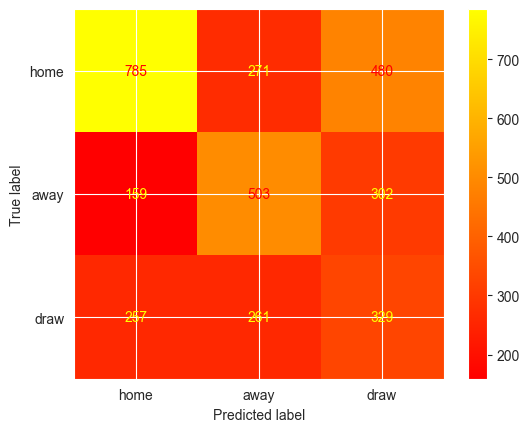

In [59]:
class_counts = np.bincount(y_train)
class_weights = {i: len(y_train) / (3 * c) for i, c in enumerate(class_counts)}

param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['sag', 'saga'],
}

logreg = LogisticRegression(
    class_weight=class_weights,
    max_iter=2000,
    random_state=91
)

grid_search = GridSearchCV(logreg, param_grid, cv=8, scoring='f1_macro', n_jobs=-1, verbose=1)
grid_search.fit(X_train_scaled, y_train)
best_clf = grid_search.best_estimator_
scores = cross_val_score(best_clf, X, y, cv=8, scoring='accuracy')
print("Best Params:", grid_search.best_params_)

best_clf.fit(X_train, y_train)

# tests
y_pred = best_clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

print(cm)
print(classification_report(y_test, y_pred, target_names=['home','away','draw']))

ConfusionMatrixDisplay(cm, display_labels=['home','away','draw']).plot(cmap='autumn')

# Сохранение
with open('../backend/goalsight/ml_models/model.pkl', 'wb') as f:
    pickle.dump(best_clf, f)

metrics = {
    'cv_accuracy': scores.mean(),
    'cv_std': scores.std(),
    **classification_report(y_test, y_pred, output_dict=True)
}

metrics_path = '../backend/goalsight/ml_models/metrics.json'
with open(metrics_path, 'w') as f:
    json.dump(metrics, f, indent=2)

with open('../backend/goalsight/ml_models/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

feature_list = [f for f in available_features if f != 'result_label']
with open('features.json', 'w') as f:
    json.dump(feature_list, f)

class_mapping = {'home_win': 0, 'away_win': 1, 'draw': 2}
with open('class_mapping.json', 'w') as f:
    json.dump(class_mapping, f)